In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm  # Progress bar
import dill

from ValueTensor import Value, ValueTensor, criterion
from Layer import initialization, Layer, OutputLayer
from model import FFNN

# Load Dataset

In [2]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
Y = np.eye(10)[y.astype(int)] # one hot encoding untuk output

In [3]:
# normalisasi value
# asumsi dataset tidak berubah
X_normalized = X / 255
Y_normalized = Y / 255

In [4]:
# ambil sebagian data set karena terlalu lama
n = 14

X_sliced = X_normalized[:n]
Y_sliced = Y_normalized[:n]

In [5]:
# split training and validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_sliced, Y_sliced, test_size=1/7, random_state=42)

In [7]:
# untuk lebih mudah plotting hasil akhir (grafik training loss dan validation loss)

def plot_loss(train_l, val_l):
    # kedua input berbentuk array
    e = np.arange(1, len(train_l)+1) 

    plt.figure(figsize=(8, 5))
    plt.plot(e, train_l, marker='o', label='Training loss')
    plt.plot(e, val_l, marker='s', label='Validation loss')

    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Grafik Loss setiap epoch")
    plt.legend()
    plt.grid()
    plt.show()

# Test save and load model

In [7]:
ModelSigmaSkibidi = FFNN(2, [3, 4, 5], 10, ["linear", "relu", "sigmoid", "softmax"], "mse", [("zero", -1, 1, 42, "he") for _ in range (4)])
ModelSigmaSkibidi.save_model("mokel.pkl")

Model saved to mokel.pkl


In [14]:
ModelHawkTuah = FFNN.load_model("mokel.pkl")
print(ModelHawkTuah.input_size)
print(ModelHawkTuah.hidden_size_array)
print(ModelHawkTuah.output_size)
print(ModelHawkTuah.num_neurons)
print(ModelHawkTuah.activation_function)
print(ModelHawkTuah.loss_function)
print(ModelHawkTuah.weight_init)
print(ModelHawkTuah.input_and_hidden_layers[0].weights)

Model loaded from mokel.pkl
2
[3 4 5]
10
[ 2  3  4  5 10]
['linear', 'relu', 'sigmoid', 'softmax']
mse
[('zero', -1, 1, 42, 'he'), ('zero', -1, 1, 42, 'he'), ('zero', -1, 1, 42, 'he'), ('zero', -1, 1, 42, 'he')]
ValueTensor(
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]])


# Test pengaruh depth

Epoch 1/3: 100%|██████████| 7/7 [00:10<00:00,  1.49s/batch, Batch Loss=0.0127]


Epoch 1: Train Loss = 0.012792385557720368, Val Loss = 0.012604176080674368


Epoch 2/3: 100%|██████████| 7/7 [00:21<00:00,  3.02s/batch, Batch Loss=0.0125]


Epoch 2: Train Loss = 0.012536495546265146, Val Loss = 0.012364014602359117


Epoch 3/3: 100%|██████████| 7/7 [00:31<00:00,  4.52s/batch, Batch Loss=0.0122]

Epoch 3: Train Loss = 0.012304516578415576, Val Loss = 0.012146547121955738


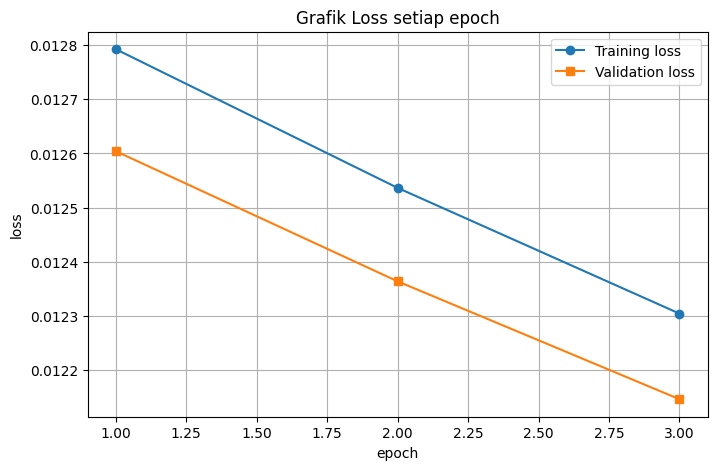

In [10]:
# 3 hidden layer
Depth1 = FFNN(784, [3, 3, 3], 10, ["sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (4)])
train_loss, val_loss = Depth1.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
plot_loss(train_loss, val_loss)

Epoch 1/3: 100%|██████████| 7/7 [00:15<00:00,  2.24s/batch, Batch Loss=0.0127]


Epoch 1: Train Loss = 0.012788644640985744, Val Loss = 0.012599393455763908


Epoch 2/3: 100%|██████████| 7/7 [00:29<00:00,  4.28s/batch, Batch Loss=0.0125]


Epoch 2: Train Loss = 0.012530933635128985, Val Loss = 0.01235787331039109


Epoch 3/3: 100%|██████████| 7/7 [00:42<00:00,  6.07s/batch, Batch Loss=0.0122]

Epoch 3: Train Loss = 0.012297819570867582, Val Loss = 0.012139557646418019


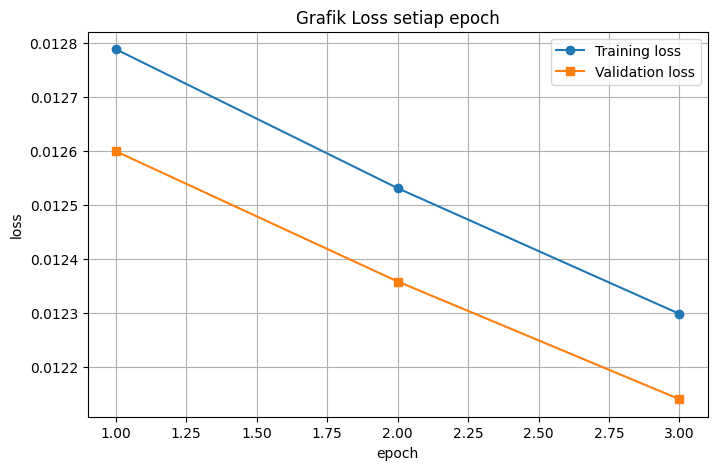

In [12]:
# 5 hidden layer
Depth2 = FFNN(784, [3, 3, 3, 3, 3], 10, ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (6)])
train_loss, val_loss = Depth2.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
plot_loss(train_loss, val_loss)

Epoch 1/3: 100%|██████████| 7/7 [00:13<00:00,  1.86s/batch, Batch Loss=0.0127]


Epoch 1: Train Loss = 0.012788945326277284, Val Loss = 0.012599533918442523


Epoch 2/3: 100%|██████████| 7/7 [00:37<00:00,  5.33s/batch, Batch Loss=0.0125]


Epoch 2: Train Loss = 0.012531336279047825, Val Loss = 0.012358063996103626


Epoch 3/3: 100%|██████████| 7/7 [00:57<00:00,  8.23s/batch, Batch Loss=0.0122]

Epoch 3: Train Loss = 0.012298300649809952, Val Loss = 0.012139787389955381


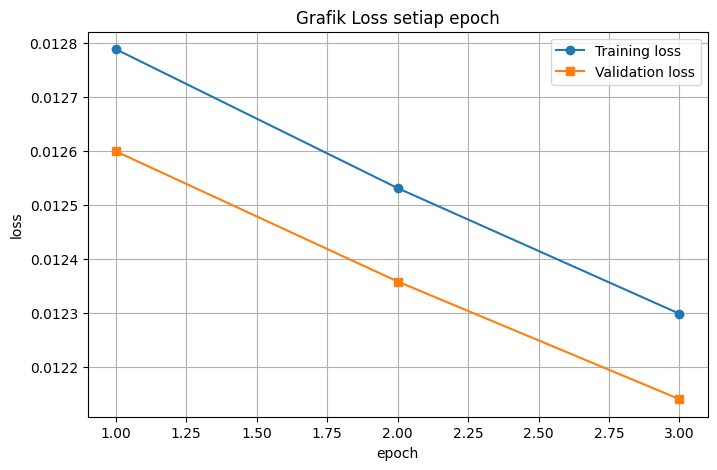

In [13]:
# 7 hidden layer
Depth3 = FFNN(784, [3, 3, 3, 3, 3, 3, 3], 10, ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (8)])
train_loss, val_loss = Depth3.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
plot_loss(train_loss, val_loss)

# Test pengaruh width

Epoch 1/3: 100%|██████████| 7/7 [00:06<00:00,  1.15batch/s, Batch Loss=0.0127]


Epoch 1: Train Loss = 0.012789099377623405, Val Loss = 0.012598836615021907


Epoch 2/3: 100%|██████████| 7/7 [00:27<00:00,  4.00s/batch, Batch Loss=0.0125]


Epoch 2: Train Loss = 0.012531588766613715, Val Loss = 0.012357336809328542


Epoch 3/3: 100%|██████████| 7/7 [00:31<00:00,  4.54s/batch, Batch Loss=0.0122]

Epoch 3: Train Loss = 0.012298692092989805, Val Loss = 0.012139085466174702


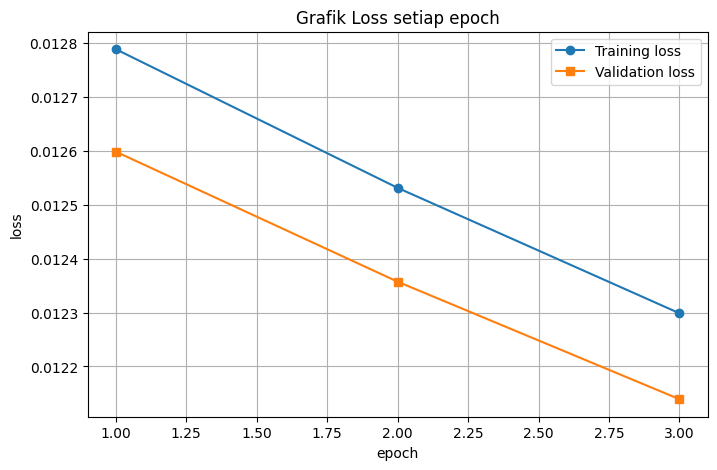

In [14]:
# 3 neuron per layer
Width1 = FFNN(784, [3, 3, 3, 3], 10, ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (5)])
train_loss, val_loss = Width1.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
plot_loss(train_loss, val_loss)

Epoch 1/3: 100%|██████████| 7/7 [00:18<00:00,  2.62s/batch, Batch Loss=0.0145]


Epoch 1: Train Loss = 0.01475953992802651, Val Loss = 0.014378807312664913


Epoch 2/3: 100%|██████████| 7/7 [00:39<00:00,  5.68s/batch, Batch Loss=0.014]


Epoch 2: Train Loss = 0.014235781370528089, Val Loss = 0.013943862855979192


Epoch 3/3: 100%|██████████| 7/7 [00:54<00:00,  7.79s/batch, Batch Loss=0.0137]

Epoch 3: Train Loss = 0.013832961434011337, Val Loss = 0.013600772221046468


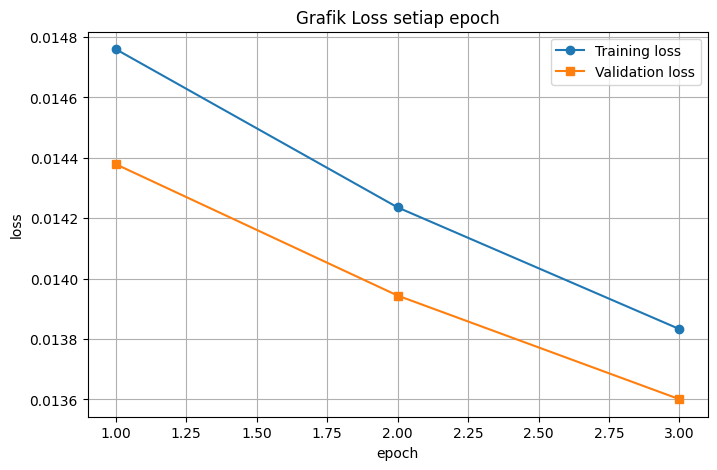

In [15]:
# 5 neuron per layer
Width2 = FFNN(784, [5, 5, 5, 5], 10, ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (5)])
train_loss, val_loss = Width2.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
plot_loss(train_loss, val_loss)

Epoch 1/3: 100%|██████████| 7/7 [00:45<00:00,  6.53s/batch, Batch Loss=0.017]


Epoch 1: Train Loss = 0.018201091819178682, Val Loss = 0.016607911427257503


Epoch 2/3: 100%|██████████| 7/7 [01:29<00:00, 12.80s/batch, Batch Loss=0.0154]


Epoch 2: Train Loss = 0.015920538710157833, Val Loss = 0.015144252159189341


Epoch 3/3: 100%|██████████| 7/7 [02:35<00:00, 22.15s/batch, Batch Loss=0.0144]

Epoch 3: Train Loss = 0.014730452382353232, Val Loss = 0.014227647340142768


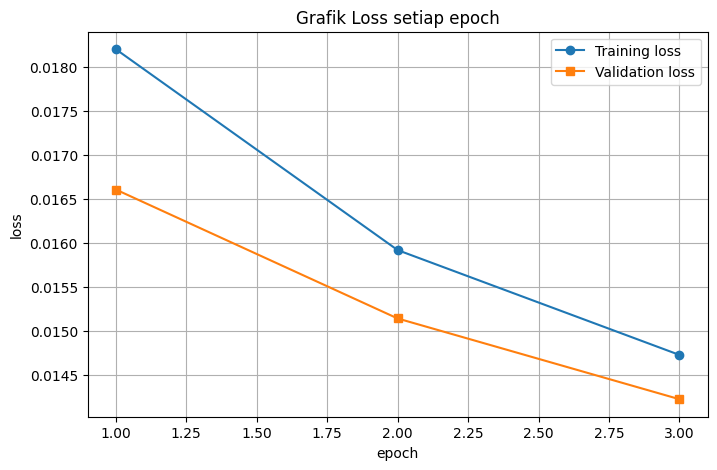

In [16]:
# 10 neuron per layer
Width3 = FFNN(784, [10, 10, 10, 10], 10, ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "softmax"], "mse", [("uniform", -1, 1, 42, "random") for _ in range (5)])
train_loss, val_loss = Width3.train_model(2, 0.1, 3, X_train, Y_train, X_val, Y_val, 1)
plot_loss(train_loss, val_loss)